In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/drive/MyDrive/chest_xray_2/train')
test = get_training_data('/content/drive/MyDrive/chest_xray_2/test')
val = get_training_data('/content/drive/MyDrive/chest_xray_2/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


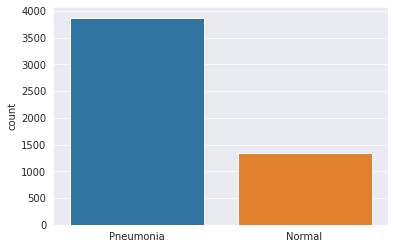

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

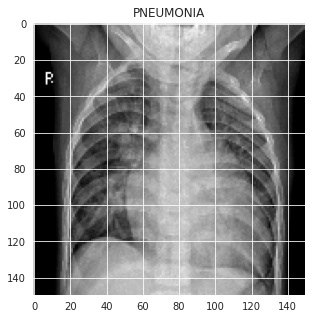

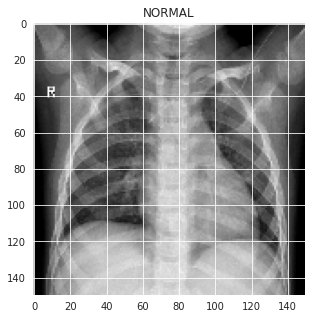

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## **Model 1 **
- augmentacja = datagen
- wartstwy = layers: Conv2D, AveragePolling2D, BatchNormalization, Dropout, Flatten, Dense
- optymalizator: adam
- lr = 0.001
- funkcja błędu = BinaryCrossentropy
- metryka = accuracy
- padding dla AveragePolling2D = valid
- funkcja = 'relu' oprócz ostatniej 'sigmoid'

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range = 20,
        zoom_range = 0.1,  
        width_shift_range=0.05,  
        height_shift_range=0.05,  
        horizontal_flip = True,  
        vertical_flip=False)  


datagen.fit(x_train)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
adamek = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam')

model.compile(optimizer=adamek,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_18 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d_12 (Avera  (None, 75, 75, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_14 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_19 (Bat  (None, 75, 75, 64)      

In [ ]:
save_path = "/Users/rafalrazny/ML/20_module/pneumonia.ckpt"
checkpoint_dir = os.path.dirname(save_path)
pneumonia_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [pneumonia_callback])

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8982
Epoch 1: saving model to /Users/rafalrazny/ML/20_module/pneumonia.ckpt
164/164 [==============================] - 264s 2s/step - loss: 0.3148 - accuracy: 0.8982 - val_loss: 3.9678 - val_accuracy: 0.5000
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9270
Epoch 2: saving model to /Users/rafalrazny/ML/20_module/pneumonia.ckpt
164/164 [==============================] - 262s 2s/step - loss: 0.1850 - accuracy: 0.9270 - val_loss: 9.4616 - val_accuracy: 0.5000
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9373
Epoch 3: saving model to /Users/rafalrazny/ML/20_module/pneumonia.ckpt
164/164 [==============================] - 265s 2s/step - loss: 0.1652 - accuracy: 0.9373 - val_loss: 5.4240 - val_accuracy: 0.5000
Epoch 4/12
164/164 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9412
Epoch 4

In [ ]:
print("Błąd modelu wynosi - " , model.evaluate(x_test,y_test)[0])
print("Współczynnik dokładności modelu wynosi - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 7s 348ms/step - loss: 0.7076 - accuracy: 0.7885
Błąd modelu wynosi -  0.7076258063316345
20/20 [==============================] - 7s 354ms/step - loss: 0.7076 - accuracy: 0.7885
Współczynnik dokładności modelu wynosi -  78.84615659713745 %


In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[273, 117],
       [ 15, 219]])

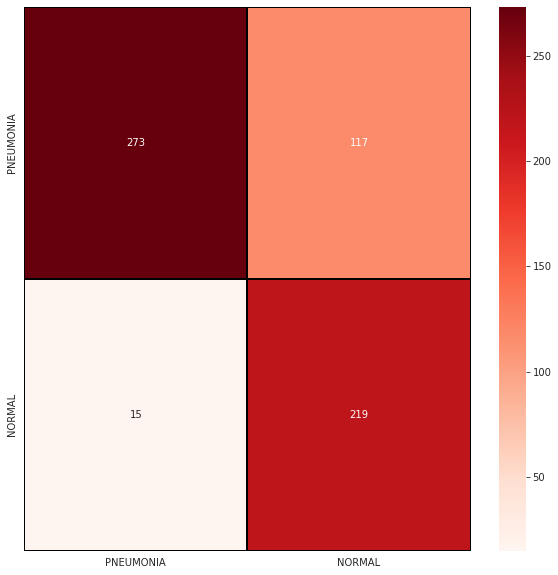

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
cm = np.array(cm)
cm

array([[273, 117],
       [ 15, 219]])

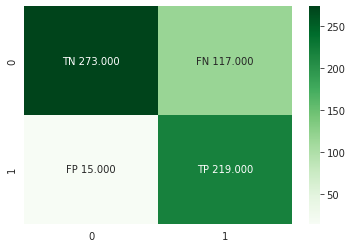

In [ ]:
results = cm
strings = strings = np.asarray([['TN', 'FN'],
                                ['FP', 'TP']])
                              

labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(strings.flatten(),
                                               results.flatten())])
         ).reshape(2, 2)

fig, ax = plt.subplots()
sns.heatmap(results, annot=labels, fmt="", cmap='Greens', ax=ax)
plt.show()

# **Model 2**

- augmentacja = datagen
- wartstwy = layers: Conv2D, MaxPool2D (ZMIANA), BatchNormalization, Dropout, Flatten, Dense
optymalizator: RMSprop
- lr = 0.002 (ZWIĘKSZENIE)
- funkcja błędu = BinaryCrossentropy
- metryka = accuracy
- padding dla MaxPool2D = 'same'
- funkcja = 'relu' oprócz ostatniej 'sigmoid'
- ZWIĘKSZENIE KERNELA w Conv2D
- ZMNIEJSZENIE jednego filtru do 128

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_16 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_17 (Bat  (None, 75, 75, 64)      

In [ ]:
eremes = tf.keras.optimizers.RMSprop(
    learning_rate=0.002,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name='RMSprop',
)
model_2.compile(optimizer= eremes,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [pneumonia_callback])

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.8396
Epoch 1: saving model to /Users/rafalrazny/ML/20_module/pneumonia.ckpt
164/164 [==============================] - 377s 2s/step - loss: 0.8846 - accuracy: 0.8396 - val_loss: 11.2148 - val_accuracy: 0.5000
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9174
Epoch 2: saving model to /Users/rafalrazny/ML/20_module/pneumonia.ckpt
164/164 [==============================] - 371s 2s/step - loss: 0.2426 - accuracy: 0.9174 - val_loss: 18.5101 - val_accuracy: 0.5000
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9377
Epoch 3: saving model to /Users/rafalrazny/ML/20_module/pneumonia.ckpt
164/164 [==============================] - 368s 2s/step - loss: 0.1823 - accuracy: 0.9377 - val_loss: 9.5846 - val_accuracy: 0.5000
Epoch 4/12
164/164 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9438
Epoch

In [ ]:
print("Błąd modelu wynosi - " , model_2.evaluate(x_test,y_test)[0])
print("Współczynnik dokładności modelu wynosi - " , model_2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 10s 485ms/step - loss: 2.2913 - accuracy: 0.7692
Błąd modelu wynosi -  2.2912819385528564
20/20 [==============================] - 9s 465ms/step - loss: 2.2913 - accuracy: 0.7692
Współczynnik dokładności modelu wynosi -  76.92307829856873 %


# **Model 3**

- augmentacja = datagen_2 (ZMIANA) - zwiększenie zoom, rotacji, zmniejszenie przesunięć.
- wartstwy = layers: Conv2D, AveragePooling2D (ZMIANA), BatchNormalization, Dropout, Flatten, Dense
- REDUKCJA ilości warstw i redukcja ilości filtrów
- optymalizator: Adam (ZMIANA)
- lr = scheduler (ZMIANA) 0.0012, 0.001 , 0.0008
- funkcja błędu = BinaryCrossentropy
- metryka = accuracy
- padding dla AveragePooling2D = 'same', jedna 'valid'
- funkcja = 'relu' oprócz ostatniej 'sigmoid'
- Zmniejszenie KERNELA w Conv2D

In [ ]:
datagen_2 = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range = 30,
        zoom_range = 0.2,  
        width_shift_range=0.15,  
        height_shift_range=0.15,  
        horizontal_flip = False,  
        vertical_flip=True)  


datagen_2.fit(x_train)

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
def const_scheduler(epoch):
    if epoch < 4:
          return 0.0012
    elif epoch < 8:
          return 0.001
    else:
          return 0.0008

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(const_scheduler)

In [ ]:
model_3.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(datagen_2.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen_2.flow(x_val, y_val) ,callbacks = [lr_scheduler])

Epoch 1/12
164/164 [==============================] - 255s 2s/step - loss: 0.5291 - accuracy: 0.8185 - val_loss: 0.9243 - val_accuracy: 0.5625 - lr: 0.0012
Epoch 2/12
164/164 [==============================] - 254s 2s/step - loss: 0.3195 - accuracy: 0.8691 - val_loss: 8.9056 - val_accuracy: 0.5000 - lr: 0.0012
Epoch 3/12
164/164 [==============================] - 263s 2s/step - loss: 0.2943 - accuracy: 0.8762 - val_loss: 8.2153 - val_accuracy: 0.5000 - lr: 0.0012
Epoch 4/12
164/164 [==============================] - 262s 2s/step - loss: 0.2665 - accuracy: 0.8877 - val_loss: 4.7979 - val_accuracy: 0.5000 - lr: 0.0012
Epoch 5/12
164/164 [==============================] - 263s 2s/step - loss: 0.2493 - accuracy: 0.9007 - val_loss: 1.0329 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/12
164/164 [==============================] - 262s 2s/step - loss: 0.2371 - accuracy: 0.9045 - val_loss: 1.2819 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/12
164/164 [==============================] - 260s 2s/st

In [ ]:
print("Błąd modelu wynosi - " , model_3.evaluate(x_test,y_test)[0])
print("Współczynnik dokładności modelu wynosi - " , model_3.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 6s 318ms/step - loss: 2.1621 - accuracy: 0.4663
Błąd modelu wynosi -  2.1620638370513916
20/20 [==============================] - 7s 326ms/step - loss: 2.1621 - accuracy: 0.4663
Współczynnik dokładności modelu wynosi -  46.63461446762085 %


## **Model 4**

- augmentacja = datagen_3 (ZMIANA) - zmniejszenie zoom, zwiększenie przesunięć.
- wartstwy = layers: Conv2D, AveragePooling2D, BatchNormalization, Dropout, Flatten, Dense
- WZROST ilości warstw i WZROST ilości filtrów
- optymalizator: Adam
- lr = scheduler (ZMIANA) 0.003, 0.002 , 0.001
- funkcja błędu = BinaryCrossentropy
- metryka = accuracy
- padding dla AveragePooling2D ='valid'
- funkcja = 'relu' oprócz ostatniej 'sigmoid'
- Zmniejszenie KERNELA w Conv2D dla filtrów pow.128
- Do treningu zamiast validation data wprowadzono test data(x_test, y_test).


In [ ]:
datagen_3 = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range = 30,
        zoom_range = 0.15,  
        width_shift_range=0.055,  
        height_shift_range=0.055,  
        horizontal_flip = True,  
        vertical_flip=False)  


datagen_3.fit(x_train)

In [ ]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
def const_scheduler_2(epoch):
    if epoch < 4:
          return 0.003
    elif epoch < 8:
          return 0.002
    else:
          return 0.001

lr_scheduler_2 = tf.keras.callbacks.LearningRateScheduler(const_scheduler_2)

In [ ]:
model_4.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 average_pooling2d_4 (Averag  (None, 75, 75, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [ ]:
history_4 = model_4.fit(datagen_3.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen_3.flow(x_test, y_test) ,callbacks = [lr_scheduler_2])

Epoch 1/12
164/164 [==============================] - 459s 3s/step - loss: 0.4811 - accuracy: 0.8467 - val_loss: 2.3684 - val_accuracy: 0.6266 - lr: 0.0030
Epoch 2/12
164/164 [==============================] - 470s 3s/step - loss: 0.2707 - accuracy: 0.8967 - val_loss: 8.3752 - val_accuracy: 0.6250 - lr: 0.0030
Epoch 3/12
164/164 [==============================] - 468s 3s/step - loss: 0.2095 - accuracy: 0.9214 - val_loss: 0.6505 - val_accuracy: 0.7292 - lr: 0.0030
Epoch 4/12
164/164 [==============================] - 460s 3s/step - loss: 0.2095 - accuracy: 0.9182 - val_loss: 0.7252 - val_accuracy: 0.6635 - lr: 0.0030
Epoch 5/12
164/164 [==============================] - 461s 3s/step - loss: 0.1831 - accuracy: 0.9298 - val_loss: 0.4628 - val_accuracy: 0.8301 - lr: 0.0020
Epoch 6/12
164/164 [==============================] - 459s 3s/step - loss: 0.1954 - accuracy: 0.9239 - val_loss: 0.6991 - val_accuracy: 0.7404 - lr: 0.0020
Epoch 7/12
164/164 [==============================] - 454s 3s/st

In [ ]:
print("Błąd modelu wynosi - " , model_4.evaluate(x_test,y_test)[0])
print("Współczynnik dokładności modelu wynosi - " , model_4.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 18s 861ms/step - loss: 0.4587 - accuracy: 0.8381
Błąd modelu wynosi -  0.458677738904953
20/20 [==============================] - 12s 590ms/step - loss: 0.4587 - accuracy: 0.8381
Współczynnik dokładności modelu wynosi -  83.81410241127014 %


# **Obserwacje:**
- redukcja ilości warstw zmniejszyła dokładność modelu
- redukcja ilości warstw nie była zrekompensowana większą augmentacją i większą learning_rate
- optymalizator 'adam' dał lepsze wyniki niż 'RMSprop'
- warstwa AveragePooling2D dała lepsze wyniki niż MaxPool2D
- użycie schedulera dla 3 wariantów learning_rate (0.003, 0.002, 0.001) dało dobre rezultaty
- zwiększenie filtrów i ilości warstw miało znaczący wpływ na zwiększenie czasochłonności obliczeń.
- najlepszy wynik osiągnięto dla modelu 4., tj. 0.84% accuracy, który był najbardziej złożonym, z największą ilością warstw.